# plot

> Accurate and interative big data visualization

In [ ]:
#| default_exp cli/plot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import holoviews as hv
from holoviews import opts
import numpy as np
from bokeh.models import WheelZoomTool
import moraine.cli as mc

In [ ]:
#| export
import logging
import zarr
import numpy as np
import math
from pathlib import Path
from functools import partial
from typing import Callable
import numpy as np
from numba import prange
import holoviews as hv
from holoviews import streams

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
import time

import toml
from moraine.utils_ import ngpjit
from moraine.rtree import HilbertRtree
from moraine.cli.logging import mc_logger
from moraine.coord_ import Coord
from moraine.cli import mk_clean_dir, dask_from_zarr, dask_to_zarr, parallel_write_zarr, parallel_read_zarr

## raster plot

In [ ]:
#| export
def _ras_downsample_all_and_save(ras,zarrs,channel_idx):
    slices = [slice(None),slice(None)]
    if len(channel_idx) != 0:
        for idx in channel_idx:
            slices.append(slice(idx,idx+1))
    slices = tuple(slices)

    for level in range(len(zarrs)):
        ras_ = ras[::2**level,::2**level]
        parallel_write_zarr(ras_,zarrs[level],slices)

In [ ]:
#| export
@mc_logger
def ras_pyramid(
    ras:str, # path to input data, 2D zarr array (one single raster) or 3D zarr array (a stack of rasters)
    out_dir:str, # output directory to store rendered data
    chunks:tuple[int,int]=(256,256), # output raster tile size
    processes=False, # use process for dask worker over thread
    n_workers=1, # number of dask worker
    threads_per_worker=2, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''render raster data to pyramid of difference zoom levels.'''
    # I forget why threads_per_worker set to 2, maybe because one for data read and write and another one for process
    logger = logging.getLogger(__name__)
    logger.info('clean out dir')
    out_dir = Path(out_dir); mk_clean_dir(out_dir)

    ras_zarr = zarr.open(ras,'r')
    logger.zarr_info(ras, ras_zarr)
    
    ny, nx = ras_zarr.shape[0:2]
    n_channel = ras_zarr.ndim-2
    out_chunks = chunks
    channel_chunks = ((1,)*n_channel)
    maxlevel = math.floor(math.log2(min(nx,ny))) # so at least 2 pixels
    
    logger.info(f'rendered raster pyramid with zoom level ranging from 0 (finest resolution) to {maxlevel} (coarsest resolution).')

    with LocalCluster(processes=processes,
                      n_workers=n_workers,
                      threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        ras_data = dask_from_zarr(ras,chunks=(ny,nx,*channel_chunks))

        downsampled_ras_zarrs = []
        for level in range(maxlevel+1):
            shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)))
            downsampled_ras_store = zarr.NestedDirectoryStore(out_dir/f'{level}.zarr')
            downsampled_ras_zarr = zarr.open(
                downsampled_ras_store,'w',
                shape=(*shape,*ras_zarr.shape[2:]),
                dtype=ras_data.dtype,
                chunks=(*out_chunks,*channel_chunks),)
            logger.zarr_info(out_dir/f'{level}.zarr',downsampled_ras_zarr)
            downsampled_ras_zarrs.append(downsampled_ras_zarr)

        ras_data_delayed = ras_data.to_delayed().reshape(ras_zarr.shape[2:])
        out_delayed = np.empty_like(ras_data_delayed,dtype=object)
        downsample_save_delayed = delayed(_ras_downsample_all_and_save,pure=True,nout=0)
        
        with np.nditer(out_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as arr_it:
            for arr_block in arr_it:
                idx = arr_it.multi_index
                out_delayed[idx] = downsample_save_delayed(ras_data_delayed[idx],downsampled_ras_zarrs,idx)
                out_delayed[idx] = da.from_delayed(out_delayed[idx],shape=(1,),dtype=int)
        out = da.block(out_delayed.tolist())
        logger.info('computing graph setted. doing all the computing.')
        # dask.visualize(out,filename="ras_pyramid.svg", optimize_graph=True, color='order')
        futures = client.persist(out)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

[`ras_pyramid`](#ras_pyramid) render one single raster (2D array) or a stack of rasters (2D array) into tiles of difference resolution (zoom level).

In [ ]:
adi = 'ps/adi.zarr'
rslc = 'raw/rslc.zarr'
adi_pyramid_dir = 'plot/adi_pyramid'
rslc_pyramid_dir = 'plot/rslc_pyramid'

In [ ]:
logger = mc.get_logger()

In [ ]:
ras_pyramid(adi,adi_pyramid_dir)

2025-06-24 22:02:13 - log_args - INFO - running function: ras_pyramid
2025-06-24 22:02:13 - log_args - INFO - fetching args:
2025-06-24 22:02:13 - log_args - INFO - ras = 'ps/adi.zarr'
2025-06-24 22:02:13 - log_args - INFO - out_dir = 'plot/adi_pyramid'
2025-06-24 22:02:13 - log_args - INFO - chunks = (256, 256)
2025-06-24 22:02:13 - log_args - INFO - processes = False
2025-06-24 22:02:13 - log_args - INFO - n_workers = 1
2025-06-24 22:02:13 - log_args - INFO - threads_per_worker = 2
2025-06-24 22:02:13 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 22:02:13 - log_args - INFO - fetching args done.
2025-06-24 22:02:13 - ras_pyramid - INFO - clean out dir
2025-06-24 22:02:13 - zarr_info - INFO - ps/adi.zarr zarray shape, chunks, dtype: (2500, 1834), (1000, 1000), float32
2025-06-24 22:02:13 - ras_pyramid - INFO - rendered raster pyramid with zoom level ranging from 0 (finest resolution) to 10 (coarsest resolution).
2025-06-24 22:02:16 - ras_pyramid - INFO - dask local cluster start

In [ ]:
ras_pyramid(rslc,rslc_pyramid_dir)

2025-06-24 22:02:17 - log_args - INFO - running function: ras_pyramid
2025-06-24 22:02:17 - log_args - INFO - fetching args:
2025-06-24 22:02:17 - log_args - INFO - ras = 'raw/rslc.zarr'
2025-06-24 22:02:17 - log_args - INFO - out_dir = 'plot/rslc_pyramid'
2025-06-24 22:02:17 - log_args - INFO - chunks = (256, 256)
2025-06-24 22:02:17 - log_args - INFO - processes = False
2025-06-24 22:02:17 - log_args - INFO - n_workers = 1
2025-06-24 22:02:17 - log_args - INFO - threads_per_worker = 2
2025-06-24 22:02:17 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 22:02:17 - log_args - INFO - fetching args done.
2025-06-24 22:02:17 - ras_pyramid - INFO - clean out dir
2025-06-24 22:02:17 - zarr_info - INFO - raw/rslc.zarr zarray shape, chunks, dtype: (2500, 1834, 17), (1000, 1000, 1), complex64
2025-06-24 22:02:17 - ras_pyramid - INFO - rendered raster pyramid with zoom level ranging from 0 (finest resolution) to 10 (coarsest resolution).
2025-06-24 22:02:17 - ras_pyramid - INFO - dask local

In [ ]:
#| export
# there should be better way to achieve variable kdims, but I don't find that.
def _hv_ras_callback_0(x_range,y_range,width,height,scale,data_dir,post_proc,coord,level_increase):
    # start = time.time()
    if x_range is None:
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if y_range is None:
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res,y_res)))
    level += level_increase
    level = sorted((0, level, coord.maxlevel))[1]
    data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
    xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
    coord_bbox = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
    # decide_slice = time.time()
    data = post_proc(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1))
    # post_proc_data = time.time()
    # print(f"It takes {post_proc_data-decide_slice} to post_proc the data", file = sourceFile)
    ### test shows data read takes only 0.006 s, post_proc and data_range takes only 0.001s
    ### the majority of time is used by holoviews that I can not optimize.
    return hv.Image(data[::-1,:],bounds=coord_bbox)
def _hv_ras_callback_1(x_range,y_range,width,height,scale,data_dir,post_proc,coord,level_increase,i=0):
    if x_range is None:
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if y_range is None:
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res,y_res)))
    level = sorted((0, level, coord.maxlevel))[1]
    level += level_increase
    data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
    xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
    coord_bbox = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
    data = post_proc(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i)
    return hv.Image(data[::-1,:],bounds=coord_bbox)
def _hv_ras_callback_2(x_range,y_range,width,height,scale,data_dir,post_proc,coord,level_increase,i=0,j=0):
    if x_range is None:
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if y_range is None:
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res,y_res)))
    level = sorted((0, level, coord.maxlevel))[1]
    level += level_increase
    data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
    xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
    coord_bbox = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
    data = post_proc(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i,j)
    return hv.Image(data[::-1,:],bounds=coord_bbox)

In [ ]:
#| export
def _default_ras_post_proc(data_zarr, xslice, yslice, *kdims):
    data_n_kdim = data_zarr.ndim - 2
    assert len(kdims) == data_n_kdim
    if len(kdims) == 0:
        # zarr do not support empty tuple as input
        return data_zarr[yslice,xslice]
    else:
        index_tuple = (yslice, xslice, *kdims)
        return data_zarr[index_tuple]

In [ ]:
#| export
def _ras_inf_0_post_proc(data_zarr, xslice, yslice, *kdims):
    data_n_kdim = data_zarr.ndim - 2
    assert len(kdims) == 1
    i = kdims[0]
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,0]*data_zarr[yslice,xslice,i].conj())
        else:
            return data_zarr[yslice,xslice,0]-data_zarr[yslice,xslice,i]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,0,i])
        else:
            return data_zarr[yslice,xslice,0,i]

def _ras_inf_seq_post_proc(data_zarr, xslice, yslice, *kdims):
    data_n_kdim = data_zarr.ndim - 2
    assert len(kdims) == 1
    i = kdims[0]
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,i+1].conj())
        else:
            return data_zarr[yslice,xslice,i]-data_zarr[yslice,xslice,i+1]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,i,i+1])
        else:
            return data_zarr[yslice,xslice,i,i+1]
def _ras_inf_all_post_proc(data_zarr, xslice, yslice, *kdims):
    data_n_kdim = data_zarr.ndim - 2
    assert len(kdims) == 2
    i,j = kdims
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,j].conj())
        else:
            return data_zarr[yslice,xslice,i]-data_zarr[yslice,xslice,j]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[yslice,xslice,i,j])
        else:
            return data_zarr[yslice,xslice,i,j]

In [ ]:
#| export
def ras_plot(
    pyramid_dir:str, # directory to the rendered ras pyramid
    post_proc:Callable=None, # function for the post processing, can be None, 'intf_0', 'intf_seq', 'intf_all' or user-defined function
    n_kdim:int=None, # number of key dimensions, can only be 0 or 1 or 2, ndim of raster dataset -2 by default
    bounds:tuple=None, # bounding box (x0, y0, x_max, y_max)
    level_increase=0, # amount of zoom level increase for more clear point show and faster responds time
):
    '''plot rendered stack of ras tiles.'''
    pyramid_dir = Path(pyramid_dir)
    data_zarr = zarr.open(pyramid_dir/'0.zarr','r')
    ny, nx = data_zarr.shape[:2]
    if post_proc is None: 
        post_proc = _default_ras_post_proc
    elif post_proc == 'intf_0':
        post_proc = _ras_inf_0_post_proc
        n_kdim = 1
    elif post_proc == 'intf_seq':
        post_proc = _ras_inf_seq_post_proc
        n_kdim = 1
    elif post_proc == 'intf_all':
        post_proc = _ras_inf_all_post_proc
        n_kdim = 2

    if n_kdim is None: n_kdim = data_zarr.ndim -2 
    assert n_kdim <= 2, 'n_kdim can only be 0 or 1 or2.'
    kdims = ['i','j'][:n_kdim]

    if len(kdims) == 0:
        hv_ras_callback = _hv_ras_callback_0
    elif len(kdims) == 1:
        hv_ras_callback = _hv_ras_callback_1
    elif len(kdims) == 2:
        hv_ras_callback = _hv_ras_callback_2

    if bounds is None:
        x0 = 0; dx = 1; y0 = 0; dy = 1
    else:
        x0, y0, xm, ym = bounds
        dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)

    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_ras_callback,data_dir=pyramid_dir,
                                   post_proc=post_proc,coord=coord,level_increase=level_increase),streams=[rangexy,plotsize],kdims=kdims)
    return images

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
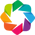

In [ ]:
hv.extension('bokeh')

`ras_plot` take the rendered raster images as the input and return a Holoviews `DynamicMap`.
It accept a post processing function for customized post processing and `n_kdim` to set number of `kdims` for returned `DynamicMap`.

Here is an example to plot the amplitude dispersion index.
We define a post processing function to mask pixels with ADI larger than 0.4:

In [ ]:
def mask_adi(data_zarr,x_slice,y_slice,):
    data = data_zarr[y_slice, x_slice]
    data[data>=0.4]=np.nan
    return data

Note that the first three arguments of `post_proc_func` have to be `data_zarr`, `x_slice`, `y_slice`.

In [ ]:
adi_plot = ras_plot(adi_pyramid_dir,post_proc=mask_adi,bounds=(0,0,1833,2499),level_increase=1)

Add annotations:

In [ ]:
adi_plot = adi_plot.redim(x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'),
                          z=hv.Dimension('adi',label='Amplitude Dispersion Index',range=(0,0.4)))

Specify plotting options and plot:

In [ ]:
adi_plot.opts(opts.Image(cmap='fire',width=600, height=400, colorbar=True,
                         invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        ))

:DynamicMap   []
   :Image   [r,az]   (adi)

![Raster Plot](./plot/raster_plot.gif)

`ras_plot` can also take stack of raster images. It will return `DynamicMap` with `keys`.
Here we define a function to generate interferograms with the first SLC as reference:

In [ ]:
def intf_0(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,0]*data_zarr[yslice,xslice,i].conj())

In [ ]:
intf_plot = ras_plot(rslc_pyramid_dir,post_proc=intf_0, level_increase=0)

We have a set of convenient predefined `post_proc` functions, e.g., `intf_0`, `intf_seq`, `intf_all`.
The above code equals to:

In [ ]:
intf_plot = ras_plot(rslc_pyramid_dir,post_proc='intf_0', level_increase=0)

Add annotations:

In [ ]:
dates = ["20210802", "20210816", "20210830", "20210913", "20211011", "20211025", "20220606", "20220620",
         "20220704", "20220718", "20220801", "20220815", "20220829", "20220912", "20220926", "20221010",
         "20221024",]
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(0,16), value_format=(lambda i: dates[0]+'_'+dates[i])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          invert_yaxis=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Phase)

In [ ]:
#![Raster Stack Plot](./plot/raster_stack_plot.gif)

Or the intensity:

In [ ]:
def intensity(data_zarr, xslice, yslice,i):
    return np.log(np.abs(data_zarr[yslice,xslice,i])**2)

int_plot = ras_plot(rslc_pyramid_dir,post_proc=intensity)
int_plot = int_plot.redim(i=hv.Dimension('i', label='Intensity', range=(1,16), value_format=(lambda i: dates[i])),
                          x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Intensity'))
int_plot.opts(opts.Image(cmap='gray',width=600, height=600, colorbar=True,
                         invert_yaxis=True, default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Intensity)

We can also plot sequential interferograms. In this case, we only plot 26 interferograms.

In [ ]:
def intf_seq(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,i+1].conj())
intf_plot = ras_plot(rslc_pyramid_dir,post_proc=intf_seq)
# or
intf_plot = ras_plot(rslc_pyramid_dir,post_proc='intf_seq')

intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(0,15), value_format=(lambda i: dates[i]+'_'+dates[i+1])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=600, colorbar=True,
                          invert_yaxis=True, default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                          active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Phase)

The `n_kdim` don't have to be `data.ndim-2`. Here is an example to show all interferograms.

In [ ]:
def intf_all(data_zarr, xslice, yslice,i,j): # we have 2 kdims here
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,j].conj())

In [ ]:
intf_plot = ras_plot(rslc_pyramid_dir,post_proc=intf_all,n_kdim=2,level_increase=0)
# or
intf_plot = ras_plot(rslc_pyramid_dir,post_proc='intf_all',n_kdim=2,level_increase=0)

Add annotations:

In [ ]:
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Reference Image', range=(0,16), value_format=(lambda i: dates[i])),
                            j=hv.Dimension('j', label='Secondary Image', range=(0,16), value_format=(lambda i: dates[i])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',frame_width=500, frame_height=600, colorbar=True,
                          invert_yaxis=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],active_tools=['wheel_zoom']))

:DynamicMap   [i,j]
   :Image   [r,az]   (Phase)

## point cloud plot

In [ ]:
#| export
@ngpjit
def _next_level_idx_from_raster_of_integer(pc_idx, nan_value):
    '''return the raster indices to the next level of raster'''
    assert pc_idx.ndim == 2
    ny, nx = pc_idx.shape
    next_ny, next_nx = math.ceil(ny/2), math.ceil(nx/2)
    xi = np.empty((next_ny,next_nx), dtype=np.int32)
    yi = np.empty((next_ny,next_nx), dtype=np.int32)

    for i in range(next_ny):
        for j in prange(next_nx):
            # Select a 2x2 box from the original array
            box = pc_idx[i*2:min(i*2+2, ny), j*2:min(j*2+2, nx)]
            idx_ = np.argwhere(box != nan_value)
            if len(idx_) == 0:
                yi[i,j]= i*2
                xi[i,j] = j*2
            else:
                yi[i,j] = idx_[0,0] + i*2
                xi[i,j] = idx_[0,1] + j*2
    return yi, xi

In [ ]:
#| hide
yi, xi = _next_level_idx_from_raster_of_integer(np.arange(10*10).reshape(10,10),0)
assert xi[0,0] == 1
np.testing.assert_array_equal(yi[:,0], np.arange(0,10,2))
np.testing.assert_array_equal(xi[1,:], np.arange(0,10,2))

In [ ]:
#| export
def _pc_downsample_all_and_save(pc,coord,gix,yis,xis,pc_zarr,ras_zarrs,channel_idx):
    pc_slices = [slice(None),]
    ras_slices = [slice(None),slice(None)]
    if len(channel_idx) != 0:
        for idx in channel_idx:
            pc_slices.append(slice(idx,idx+1))
            ras_slices.append(slice(idx,idx+1))
    pc_slices = tuple(pc_slices)
    ras_slices = tuple(ras_slices)
    parallel_write_zarr(pc,pc_zarr,pc_slices)

    ras = coord.rasterize(pc,gix)
    parallel_write_zarr(ras,ras_zarrs[0],ras_slices)

    for level in range(1,len(ras_zarrs)):
        ras = ras[yis[level-1],xis[level-1]]
        parallel_write_zarr(ras,ras_zarrs[level],ras_slices)

In [ ]:
#| export
@mc_logger
def pc_pyramid(
    pc:str, # path to point cloud data, 1D array (one single pc image) or 2D zarr array (a stack of pc images)
    out_dir:str, # output directory to store rendered data
    x:str=None, # path to x coordinate, e.g., longitude or web mercator x
    y:str=None, # path to y coordinate, e.g., latitude or web mercator y
    yx:str=None, # path to x and y coordinates. this coordinates should have shape [n_points,2]. e.g., gix
    ras_resolution:float=20, # minimum resolution of rendered raster data,
    ras_chunks:tuple[int,int]=(256,256), # output raster tile size
    pc_chunks:int=65536, # output pc tile size
    processes=False, # use process for dask worker over thread
    n_workers=1, # number of dask worker
    threads_per_worker=2, # number of threads per dask worker
    **dask_cluster_arg, # other dask local cluster args
):
    '''render point cloud data to pyramid of difference zoom levels.'''
    logger = logging.getLogger(__name__)
    logger.info('clean out dir')
    out_dir = Path(out_dir); mk_clean_dir(out_dir)

    pc_zarr = zarr.open(pc,'r')
    logger.zarr_info(pc, pc_zarr)
    
    n_pc = pc_zarr.shape[0]
    channel_chunks = (1,)*(pc_zarr.ndim-1)
    logger.info(f'rendering point cloud data coordinates:')
    if x is None and y is None:
        yx_zarr = zarr.open(yx,'r')
        assert yx_zarr.shape[1] == 2
        yx = parallel_read_zarr(yx_zarr,(slice(None),slice(0,2)))
    else:
        y_zarr = zarr.open(y,'r')
        yx = np.empty((y_zarr.shape[0],2),dtype=y_zarr.dtype)
        yx[:,0] = parallel_read_zarr(zarr.open(y,'r'),(slice(None),))
        yx[:,1] = parallel_read_zarr(zarr.open(x,'r'),(slice(None),))
    x, y = yx[:,1], yx[:,0]

    x0, xm, y0, ym = x.min(), x.max(), y.min(), y.max()
    nx, ny = math.ceil((xm-x0)/ras_resolution), math.ceil((ym-y0)/ras_resolution)
    coord = Coord(x0, ras_resolution, nx, y0, ras_resolution, ny)
    bounds = {'bounds':[x0, y0, coord.xm, coord.ym]}
    logger.info(f"rasterizing point cloud data to grid with bounds: {bounds['bounds']}.")
    with open(out_dir/'bounds.toml','w') as f:
        toml.dump(bounds, f, encoder=toml.TomlNumpyEncoder())

    gix = coord.coords2gixs(yx)
    maxlevel = coord.maxlevel

    out_x_zarr = zarr.open(out_dir/f'x.zarr','w',shape=x.shape,dtype=x.dtype,chunks=(pc_chunks,))
    out_y_zarr = zarr.open(out_dir/f'y.zarr','w',shape=y.shape,dtype=y.dtype,chunks=(pc_chunks,))
    logger.zarr_info(out_dir/f'x.zarr',out_x_zarr)
    logger.zarr_info(out_dir/f'y.zarr',out_y_zarr)
    parallel_write_zarr(x, out_x_zarr,(slice(None),))
    parallel_write_zarr(y, out_y_zarr,(slice(None),))
    del x, y, yx
    logger.info('pc data coordinates rendering ends.')

    yis = []; xis = []
    for level in range(maxlevel+1):
        if level == 0:
            current_idx = coord.rasterize_iidx(gix)
        else:
            yi, xi = _next_level_idx_from_raster_of_integer(last_idx,-1)
            yis.append(yi); xis.append(xi)
            current_idx = last_idx[yi,xi]
        out_idx_zarr = zarr.open(out_dir/f'idx_{level}.zarr',shape=current_idx.shape,dtype=current_idx.dtype,chunks=ras_chunks)
        logger.zarr_info(out_dir/f'idx_{level}.zarr',out_idx_zarr)
        parallel_write_zarr(current_idx,out_idx_zarr,(slice(None),slice(None)))
        last_idx = current_idx
    logger.info('rasterized idx rendering ends')

    with LocalCluster(processes=processes,
                      n_workers=n_workers,
                      threads_per_worker=threads_per_worker,
                      **dask_cluster_arg) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started to render pc data.')
        logger.dask_cluster_info(cluster)

        out_pc_zarr = zarr.open(out_dir/f'pc.zarr','w',shape=pc_zarr.shape, dtype=pc_zarr.dtype, chunks=(pc_chunks,*channel_chunks))
        logger.zarr_info(out_dir/f'pc.zarr', out_pc_zarr)
    
        downsampled_ras_zarrs = []
        for level in range(maxlevel+1):
            shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)))
            downsampled_ras_store = zarr.NestedDirectoryStore(out_dir/f'{level}.zarr')
            downsampled_ras_zarr = zarr.open(
                downsampled_ras_store,'w',
                shape=(*shape,*pc_zarr.shape[1:]),
                dtype=pc_zarr.dtype,
                chunks=(*ras_chunks,*channel_chunks),)
            logger.zarr_info(out_dir/f'{level}.zarr',downsampled_ras_zarr)
            downsampled_ras_zarrs.append(downsampled_ras_zarr)

        pc_darr = dask_from_zarr(pc,chunks=(n_pc,*channel_chunks))
        pc_delayed = pc_darr.to_delayed().reshape(pc_zarr.shape[1:])
        out_delayed = np.empty_like(pc_delayed,dtype=object)
        downsample_save_delayed = delayed(_pc_downsample_all_and_save,pure=True,nout=0)
        
        with np.nditer(out_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as arr_it:
            for arr_block in arr_it:
                channel_idx = arr_it.multi_index
                out_delayed[channel_idx] = downsample_save_delayed(pc_delayed[channel_idx],coord,gix, yis, xis, out_pc_zarr, downsampled_ras_zarrs,channel_idx)
                out_delayed[channel_idx] = da.from_delayed(out_delayed[channel_idx],shape=(1,),dtype=int)
        out = da.block(out_delayed.tolist())

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(out)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

`pc_pyramid` is a little bit more complex than `ras_pyramid`. The zoom level -1 is the point cloud data.
From zoom level 0 to above, the point cloud data is rasterize at different resolution.
`ras_resolution` is the parameter to set the resolution of zoom level 0.

In [ ]:
ps_can_adi = 'ps/ps_can_adi.zarr/'
ps_can_rslc = 'ps/ps_can_rslc.zarr/'
ps_can_x = './ps/ps_can_e.zarr/'
ps_can_y = './ps/ps_can_n.zarr/'
adi_pyramid_dir = 'plot/pc/adi_pyramid'
rslc_pyramid_dir = 'plot/pc/rslc_pyramid'

In [ ]:
%%time
pc_pyramid(ps_can_adi, adi_pyramid_dir, x=ps_can_x, y=ps_can_y, ras_resolution=20)

2025-06-24 22:02:23 - log_args - INFO - running function: pc_pyramid
2025-06-24 22:02:23 - log_args - INFO - fetching args:
2025-06-24 22:02:23 - log_args - INFO - pc = 'ps/ps_can_adi.zarr/'
2025-06-24 22:02:23 - log_args - INFO - out_dir = 'plot/pc/adi_pyramid'
2025-06-24 22:02:23 - log_args - INFO - x = './ps/ps_can_e.zarr/'
2025-06-24 22:02:23 - log_args - INFO - y = './ps/ps_can_n.zarr/'
2025-06-24 22:02:23 - log_args - INFO - yx = None
2025-06-24 22:02:23 - log_args - INFO - ras_resolution = 20
2025-06-24 22:02:23 - log_args - INFO - ras_chunks = (256, 256)
2025-06-24 22:02:23 - log_args - INFO - pc_chunks = 65536
2025-06-24 22:02:23 - log_args - INFO - processes = False
2025-06-24 22:02:23 - log_args - INFO - n_workers = 1
2025-06-24 22:02:23 - log_args - INFO - threads_per_worker = 2
2025-06-24 22:02:23 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 22:02:23 - log_args - INFO - fetching args done.
2025-06-24 22:02:23 - pc_pyramid - INFO - clean out dir
2025-06-24 22:02:23 

In [ ]:
%%time
pc_pyramid(ps_can_rslc, rslc_pyramid_dir, x=ps_can_x, y=ps_can_y, ras_resolution=20)

2025-06-24 22:02:24 - log_args - INFO - running function: pc_pyramid
2025-06-24 22:02:24 - log_args - INFO - fetching args:
2025-06-24 22:02:24 - log_args - INFO - pc = 'ps/ps_can_rslc.zarr/'
2025-06-24 22:02:24 - log_args - INFO - out_dir = 'plot/pc/rslc_pyramid'
2025-06-24 22:02:24 - log_args - INFO - x = './ps/ps_can_e.zarr/'
2025-06-24 22:02:24 - log_args - INFO - y = './ps/ps_can_n.zarr/'
2025-06-24 22:02:24 - log_args - INFO - yx = None
2025-06-24 22:02:24 - log_args - INFO - ras_resolution = 20
2025-06-24 22:02:24 - log_args - INFO - ras_chunks = (256, 256)
2025-06-24 22:02:24 - log_args - INFO - pc_chunks = 65536
2025-06-24 22:02:24 - log_args - INFO - processes = False
2025-06-24 22:02:24 - log_args - INFO - n_workers = 1
2025-06-24 22:02:24 - log_args - INFO - threads_per_worker = 2
2025-06-24 22:02:24 - log_args - INFO - dask_cluster_arg = {}
2025-06-24 22:02:24 - log_args - INFO - fetching args done.
2025-06-24 22:02:24 - pc_pyramid - INFO - clean out dir
2025-06-24 22:02:2

In [ ]:
#| export
def _is_nan_range(x_range):
    if x_range is None:
        return True
    if np.isnan(x_range[0]):
        return True
    if abs(x_range[1]-x_range[0]) == 0:
        return True
    return False

In [ ]:
#| export
def _hv_pc_Image_callback_0(x_range,y_range,width,height,scale,data_dir,post_proc_ras,coord,level_increase):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
        idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
        xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
        x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
        data = post_proc_ras(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1))
        idx = idx_zarr[yi0:yim+1,xi0:xim+1]
        return hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx'])
    else:
        return hv.Image([],vdims=['z','idx'])
def _hv_pc_Image_callback_1(x_range,y_range,width,height,scale,data_dir,post_proc_ras,coord,level_increase,i):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    images = []
    if level > -1:
        data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
        idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
        xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
        x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
        data = post_proc_ras(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i)
        idx = idx_zarr[yi0:yim+1,xi0:xim+1]
        return hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx'])
    else:
        return hv.Image([],vdims=['z','idx'])
def _hv_pc_Image_callback_2(x_range,y_range,width,height,scale,data_dir,post_proc_ras,coord,level_increase,i,j):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    images = []
    if level > -1:
        data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
        idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
        xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
        x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
        data = post_proc_ras(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i,j)
        idx = idx_zarr[yi0:yim+1,xi0:xim+1]
        return hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx'])
    else:
        return hv.Image([],vdims=['z','idx'])

In [ ]:
#| export
def _hv_pc_Points_callback_0(x_range,y_range,width,height,scale,data_dir,post_proc_pc,coord,rtree,level_increase):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    images = []
    if level > -1:
        return hv.Points([],vdims=['z','idx'])
    else:
        data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
        idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
        x, y = (zarr_[idx] for zarr_ in (x_zarr, y_zarr))
        data = post_proc_pc(data_zarr,idx)
        return hv.Points((x,y,data,idx),vdims=['z','idx'])
def _hv_pc_Points_callback_1(x_range,y_range,width,height,scale,data_dir,post_proc_pc,coord,rtree,level_increase,i=0):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        return hv.Points([],vdims=['z','idx'])
    else:
        data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
        idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
        x, y = (zarr_[idx] for zarr_ in (x_zarr, y_zarr))
        data = post_proc_pc(data_zarr,idx,i)
        return hv.Points((x,y,data,idx),vdims=['z','idx'])
def _hv_pc_Points_callback_2(x_range,y_range,width,height,scale,data_dir,post_proc_pc,coord,rtree,level_increase,i=0,j=0):
    if _is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if _is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level += level_increase
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        return hv.Points([],vdims=['z','idx'])
    else:
        data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
        idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
        x, y = (zarr_[idx] for zarr_ in (x_zarr, y_zarr))
        data = post_proc_pc(data_zarr,idx,i,j)
        return hv.Points((x,y,data,idx),vdims=['z','idx'])

In [ ]:
#| export
def _default_pc_post_proc(data_zarr, idx_array, *kdims):
    data_n_kdim = data_zarr.ndim - 1
    assert len(kdims) == data_n_kdim
    if len(kdims) == 0:
        return data_zarr[idx_array]
    else:
        index_tuple = (idx_array, *kdims)
        return data_zarr[index_tuple]

In [ ]:
#| export
def _pc_inf_0_post_proc(data_zarr, idx_array, *kdims):
    data_n_kdim = data_zarr.ndim - 1
    assert len(kdims) == 1
    i = kdims[0]
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,0]*data_zarr[idx_array,i].conj())
        else:
            return data_zarr[idx_array,0]-data_zarr[idx_array,i]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,0,i])
        else:
            return data_zarr[idx_array,0,i]

def _pc_inf_seq_post_proc(data_zarr, idx_array, *kdims):
    data_n_kdim = data_zarr.ndim - 1
    assert len(kdims) == 1
    i = kdims[0]
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,i]*data_zarr[idx_array,i+1].conj())
        else:
            return data_zarr[idx_array,i]-data_zarr[idx_array,i+1]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,i,i+1])
        else:
            return data_zarr[idx_array,i,i+1]

def _pc_inf_all_post_proc(data_zarr, idx_array, *kdims):
    data_n_kdim = data_zarr.ndim - 1
    assert len(kdims) == 2
    i,j = kdims
    if data_n_kdim == 1:
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,i]*data_zarr[idx_array,j].conj())
        else:
            return data_zarr[idx_array,i]-data_zarr[idx_array,j]
    else:
        assert data_n_kdim == 2
        if np.iscomplexobj(data_zarr):
            return np.angle(data_zarr[idx_array,i,j])
        else:
            return data_zarr[idx_array,i,j]

In [ ]:
#| export
def pc_plot(
    pyramid_dir:str, # directory to the rendered point cloud pyramid
    post_proc_ras:Callable=None, # function for the post processing
    post_proc_pc:Callable=None, # function for the post processing
    n_kdim:int=None, # number of key dimensions, can only be 0 or 1 or 2, ndim of point cloud dataset -1 by default
    rtree=None, # rtree, if not provide, will be automatically generated but may slow the program
    level_increase=0, # amount of zoom level increase for more clear point show and faster responds time
):
    '''plot rendered point cloud pyramid.'''    
    if post_proc_ras is None: post_proc_ras = _default_ras_post_proc
    if post_proc_pc is None: post_proc_pc = _default_pc_post_proc

    pyramid_dir = Path(pyramid_dir)
    data_zarr = zarr.open(pyramid_dir/'0.zarr','r')
    ny, nx = data_zarr.shape[:2]

    if post_proc_ras is None:
        post_proc_ras = _default_ras_post_proc
        post_proc_pc = _default_pc_post_proc
    elif post_proc_ras == 'intf_0':
        post_proc_ras = _ras_inf_0_post_proc
        post_proc_pc = _pc_inf_0_post_proc
        n_kdim = 1
    elif post_proc_ras == 'intf_seq':
        post_proc_ras = _ras_inf_seq_post_proc
        post_proc_pc = _pc_inf_seq_post_proc
        n_kdim = 1
    elif post_proc_ras == 'intf_all':
        post_proc_ras = _ras_inf_all_post_proc
        post_proc_pc = _pc_inf_all_post_proc
        n_kdim = 2

    if n_kdim is None: n_kdim = data_zarr.ndim -2
    assert n_kdim <= 2, 'n_kdim can only be 0 or 1 or2.'
    kdims = ['i','j'][:n_kdim]
    
    with open(pyramid_dir/'bounds.toml','r') as f:
        x0, y0, xm, ym = toml.load(f)['bounds']

    dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    
    if rtree is None:
        x = zarr.open(pyramid_dir/'x.zarr','r')[:]
        y = zarr.open(pyramid_dir/'y.zarr','r')[:]
        rtree = HilbertRtree.build(x,y,page_size=512)

    if len(kdims) == 0:
        hv_pc_Image_callback = _hv_pc_Image_callback_0
        hv_pc_Points_callback = _hv_pc_Points_callback_0
    elif len(kdims) == 1:
        hv_pc_Image_callback = _hv_pc_Image_callback_1
        hv_pc_Points_callback = _hv_pc_Points_callback_1
    elif len(kdims) == 2:
        hv_pc_Image_callback = _hv_pc_Image_callback_2
        hv_pc_Points_callback = _hv_pc_Points_callback_2

    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_pc_Image_callback,data_dir=pyramid_dir,
                                   post_proc_ras=post_proc_ras,coord=coord,level_increase=level_increase),
                           streams=[rangexy,plotsize],kdims=kdims)
    points = hv.DynamicMap(partial(hv_pc_Points_callback,data_dir=pyramid_dir,
                                   post_proc_pc=post_proc_pc,coord=coord,rtree=rtree,level_increase=level_increase),
                           streams=[rangexy,plotsize],kdims=kdims)
    return images*points

`pc_plot` take the rendered point cloud dataset as the input and return a Holoviews `DynamicMap`.
When the zoom level is -1, it plot the the raw point cloud data.
When the zoom level is 0 or over 0, it plot the rasterized images.
Just as `ras_plot`,  it accept post processing functions for both point cloud data and raster data to be plot.
It is the user's duty to esure the post processing fuctions coincide with each other.
It also accept `n_kdim` to set number of `kdims` for returned `DynamicMap`. 

Here is an example to plot the amplitude dispersion index:

In [ ]:
adi_plot = pc_plot(adi_pyramid_dir,level_increase=1)

Add annotations:

In [ ]:
adi_plot = adi_plot.redim(x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'),
                          z=hv.Dimension('adi',label='Amplitude Dispersion Index',range=(0,0.3))
                         )

Specify plotting options and plot:

In [ ]:
adi_plot.opts(opts.Image(cmap='fire',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        ),
              opts.Points(color='adi', cmap='fire',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        )
             )

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [lon,lat]   (adi,idx)
      .Points.I :Points   [lon,lat]   (adi,idx)

![pc_plot](./plot/pc_plot.gif)

Add the optical image as the background:

In [ ]:
hv.element.tiles.EsriImagery()*adi_plot

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Image.I  :Image   [lon,lat]   (adi,idx)
      .Points.I :Points   [lon,lat]   (adi,idx)

![pc_tiles_plot](./plot/pc_tiles_plot.gif)

Note that, for displaying data over tiles, the data have to be projected to the Web Mercator Projection.

As `ras_plot`, `pc_plot` can also take stack of point cloud dataset.
It will return `DynamicMap` with `keys`.
Here we define a function to generate interferograms with the first SLC as reference:

In [ ]:
def intf_0_pc(data_zarr,idx_array,i):
    return np.angle(data_zarr[idx_array,0]*data_zarr[idx_array,i].conj())
def intf_0_ras(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,0]*data_zarr[yslice,xslice,i].conj())

In [ ]:
intf_plot = pc_plot(rslc_pyramid_dir,post_proc_ras=intf_0_ras, post_proc_pc=intf_0_pc, level_increase=1)
# or
intf_plot = pc_plot(rslc_pyramid_dir,post_proc_ras='intf_0', post_proc_pc='intf_0', level_increase=1)

Add annotations:

In [ ]:
dates = ["20210802", "20210816", "20210830", "20210913", "20211011", "20211025", "20220606", "20220620",
         "20220704", "20220718", "20220801", "20220815", "20220829", "20220912", "20220926", "20221010",
         "20221024",]
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(0,16), value_format=(lambda i: dates[0]+'_'+dates[i])),
                            x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                          active_tools=['wheel_zoom']
                         ),
              opts.Points(color='Phase', cmap='colorwheel',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        )
              )

:DynamicMap   [i]
   :Overlay
      .Image.I  :Image   [lon,lat]   (Phase,idx)
      .Points.I :Points   [lon,lat]   (Phase,idx)

In [ ]:
#![pc_stack_plot](./plot/pc_stack_plot.gif)

The `n_kdim` don't have to be `data.ndim-1`. Here is an example to show all interferograms.

In [ ]:
def intf_pc(data_zarr, idx_arr,i,j): # we have 2 kdims here
    return np.angle(data_zarr[idx_arr,i]*data_zarr[idx_arr,j].conj())
def intf_ras(data_zarr, xslice, yslice,i,j): # we have 2 kdims here
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,j].conj())

In [ ]:
intf_plot = pc_plot(rslc_pyramid_dir,post_proc_ras=intf_ras, post_proc_pc=intf_pc,n_kdim=2,level_increase=0)
# or
intf_plot = pc_plot(rslc_pyramid_dir,post_proc_ras='intf_all', post_proc_pc='intf_all',n_kdim=2,level_increase=0)

Add annotations:

In [ ]:
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Reference Image', range=(0,16), value_format=(lambda i: dates[i])),
                            j=hv.Dimension('j', label='Secondary Image', range=(0,16), value_format=(lambda i: dates[i])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                          active_tools=['wheel_zoom']
                         ),
              opts.Points(color='Phase', cmap='colorwheel',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        )
              )

:DynamicMap   [i,j]
   :Overlay
      .Image.I  :Image   [r,az]   (Phase,idx)
      .Points.I :Points   [r,az]   (Phase,idx)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()